In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100) # 100 yerine None yazilabiliyormus

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [2]:
def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting','KNeighborsRegressor','Decision Tree','XGBRegressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

### Data Description

File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

## Import Data

In [3]:
df_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')

In [4]:
# Train datasinda sadece test datasinda olan magaza ve itemlar olmali
test_shops = df_test.shop_id.unique()
df_train = df_train[df_train.shop_id.isin(test_shops)] 
test_items = df_test.item_id.unique()
df_train = df_train[df_train.item_id.isin(test_items)]

In [5]:
from IPython.core import display as ICD

for i in [df_train, items, shops, item_cat, df_test, submission]:
    ICD.display(i.head(3))

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [6]:
df_train = pd.merge(df_train, items.drop(columns='item_name'))

In [7]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,02.01.2013,0,25,22154,999.0,1.0,37
3,03.01.2013,0,25,22154,999.0,1.0,37
4,20.01.2013,0,25,22154,999.0,1.0,37


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224439 entries, 0 to 1224438
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              1224439 non-null  object 
 1   date_block_num    1224439 non-null  int64  
 2   shop_id           1224439 non-null  int64  
 3   item_id           1224439 non-null  int64  
 4   item_price        1224439 non-null  float64
 5   item_cnt_day      1224439 non-null  float64
 6   item_category_id  1224439 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 74.7+ MB


In [9]:
df_test = pd.merge(df_test, items.drop(columns='item_name'))
df_test['date_block_num'] = 34
df_test.head()

,ID,shop_id,item_id,item_category_id,date_block_num
0,0,5,5037,19,34
1,5100,4,5037,19,34
2,10200,6,5037,19,34
3,15300,3,5037,19,34
4,20400,2,5037,19,34


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   ID                214200 non-null  int64
 1   shop_id           214200 non-null  int64
 2   item_id           214200 non-null  int64
 3   item_category_id  214200 non-null  int64
 4   date_block_num    214200 non-null  int64
dtypes: int64(5)
memory usage: 9.8 MB


## Data Visualization

In [11]:
grouped = pd.DataFrame(df_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
grouped.head()

,shop_id,date_block_num,item_cnt_day
0,2,0,248.0
1,2,1,135.0
2,2,2,237.0
3,2,3,168.0
4,2,4,159.0


In [12]:
[sorted(test_shops)[4*i:4*i+4] for i in range(11)]

[[2, 3, 4, 5],
 [6, 7, 10, 12],
 [14, 15, 16, 18],
 [19, 21, 22, 24],
 [25, 26, 28, 31],
 [34, 35, 36, 37],
 [38, 39, 41, 42],
 [44, 45, 46, 47],
 [48, 49, 50, 52],
 [53, 55, 56, 57],
 [58, 59]]

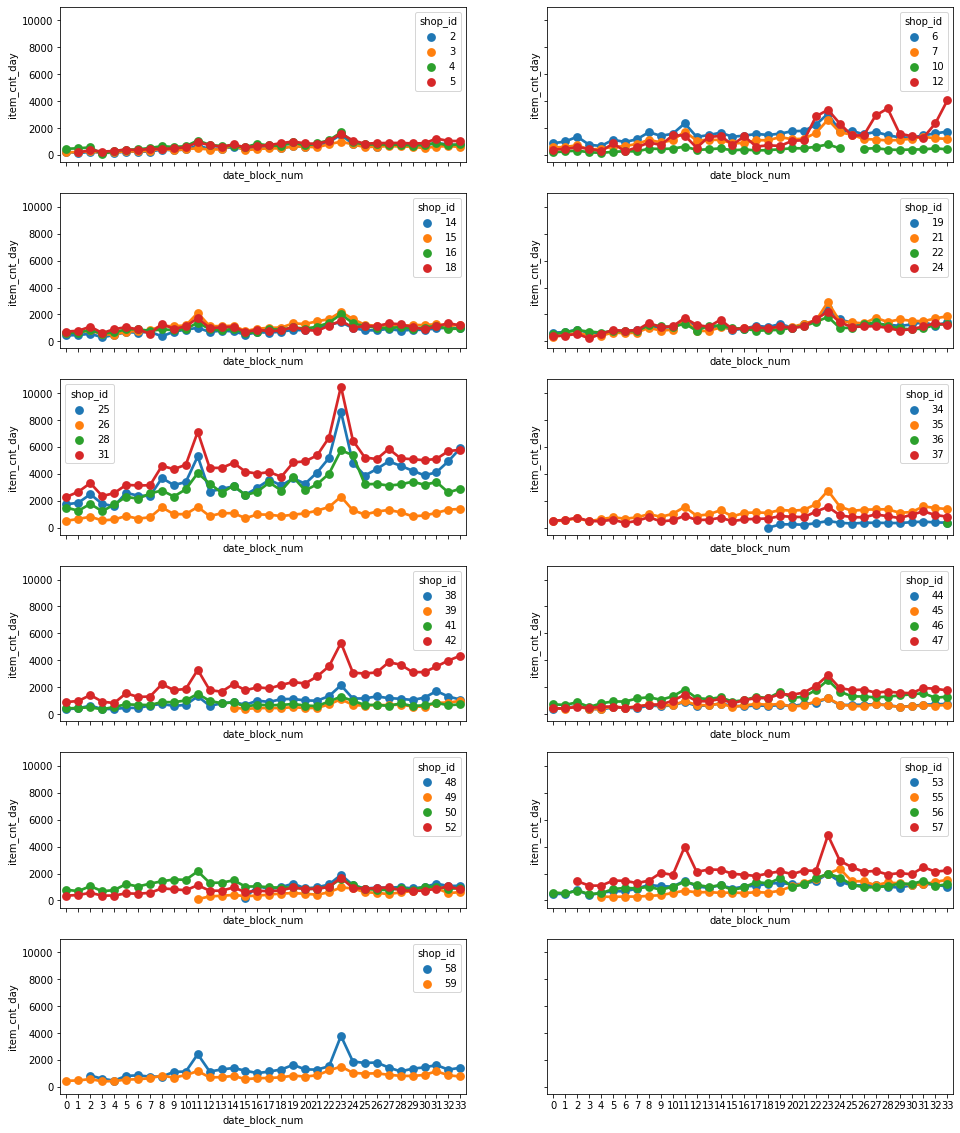

In [13]:
shops = [sorted(test_shops)[4*i:4*i+4] for i in range(11)]
fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True, sharey=True, figsize=(16,20))

count=-1
for i in range(6):
    for j in range(2):
        count+=1
        if count >= len(shops):
            break
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[grouped.shop_id.isin(shops[count])], ax=axes[i][j])

Her yil sonunda artis yasaniyor. Bu yuzden ay ve yillari eklersek iyi olur. Aslinda ustteki grafigin aynisini urunlere yapsak iyi olurdu ancak cok fazla urun var, bu yuzden kategorilere gore yapilabilir.

In [14]:
# date ten ay ve yil bulma
from datetime import datetime, date
df_train['month'] = df_train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
df_train['year'] = df_train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

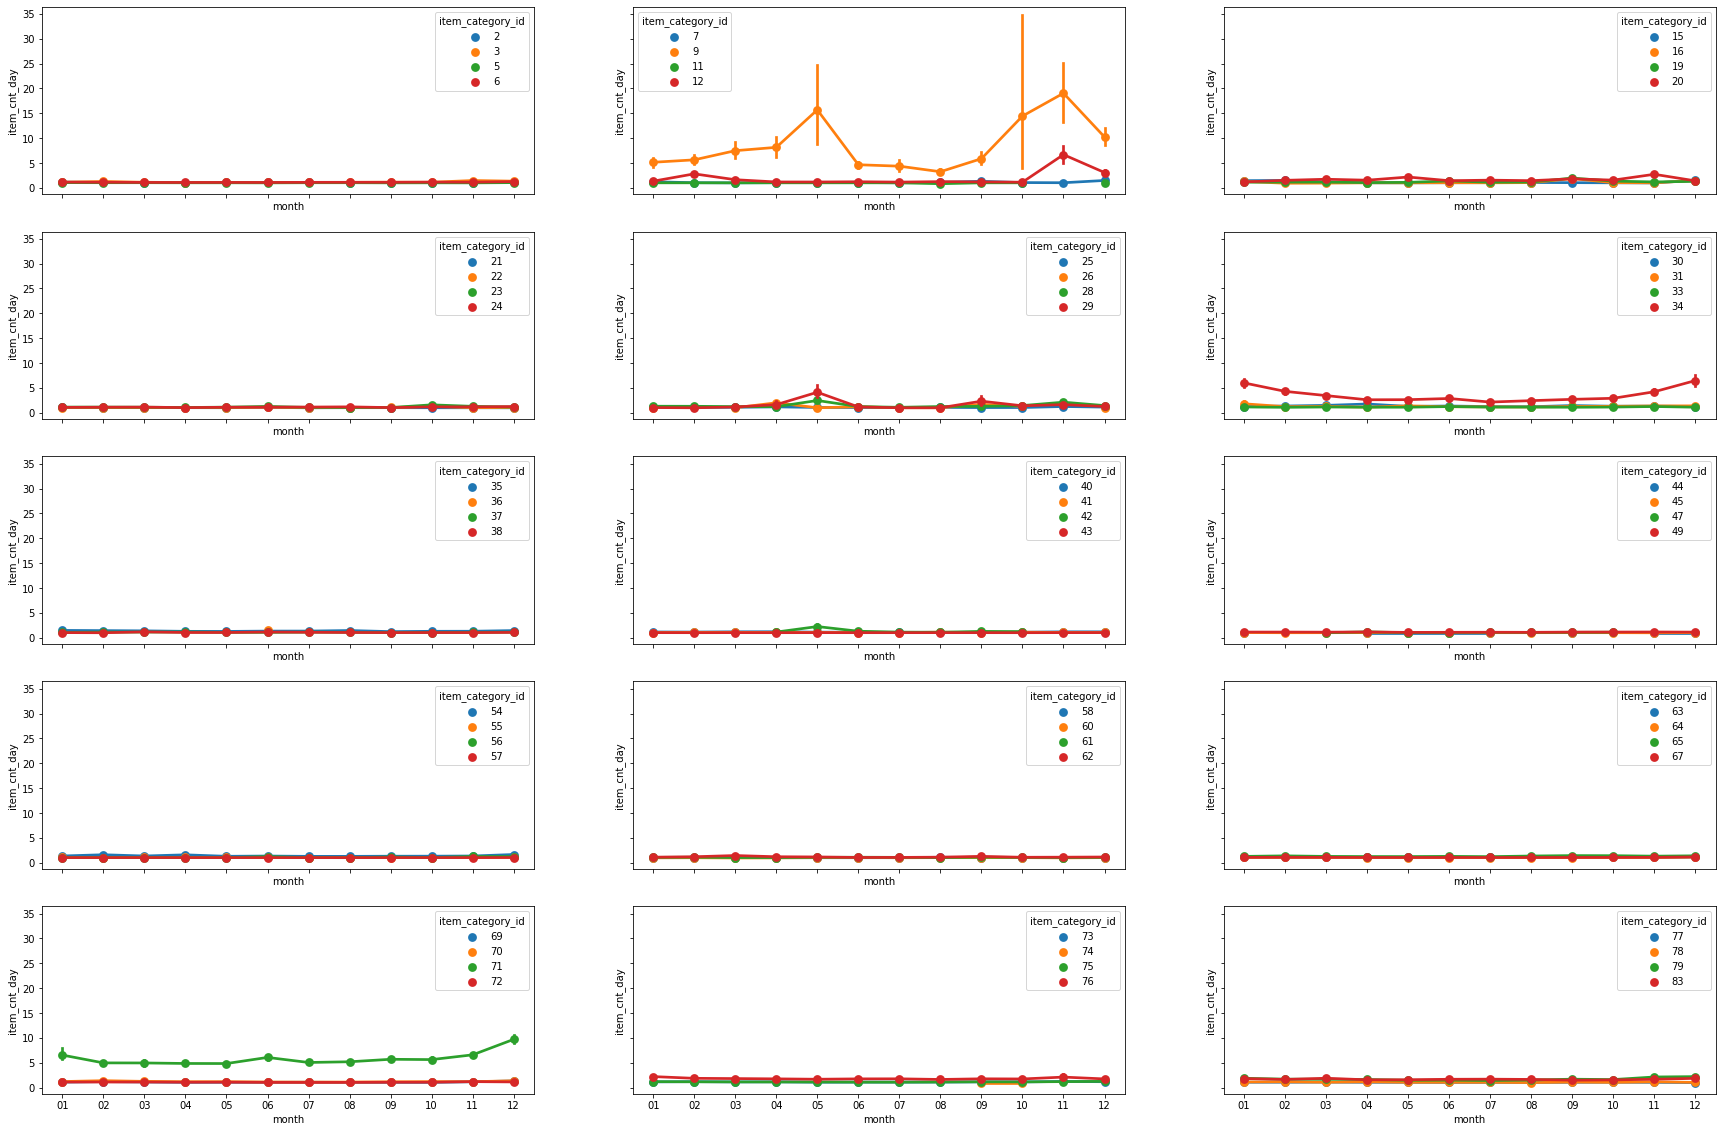

In [15]:
cats = [sorted(df_train.item_category_id.unique())[4*i:4*i+4] for i in range(15)]
fig, axes = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(30,20))

count=-1
for i in range(5):
    for j in range(3):
        count+=1
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', data=df_train[df_train.item_category_id.isin(cats[count])], ax=axes[i][j])

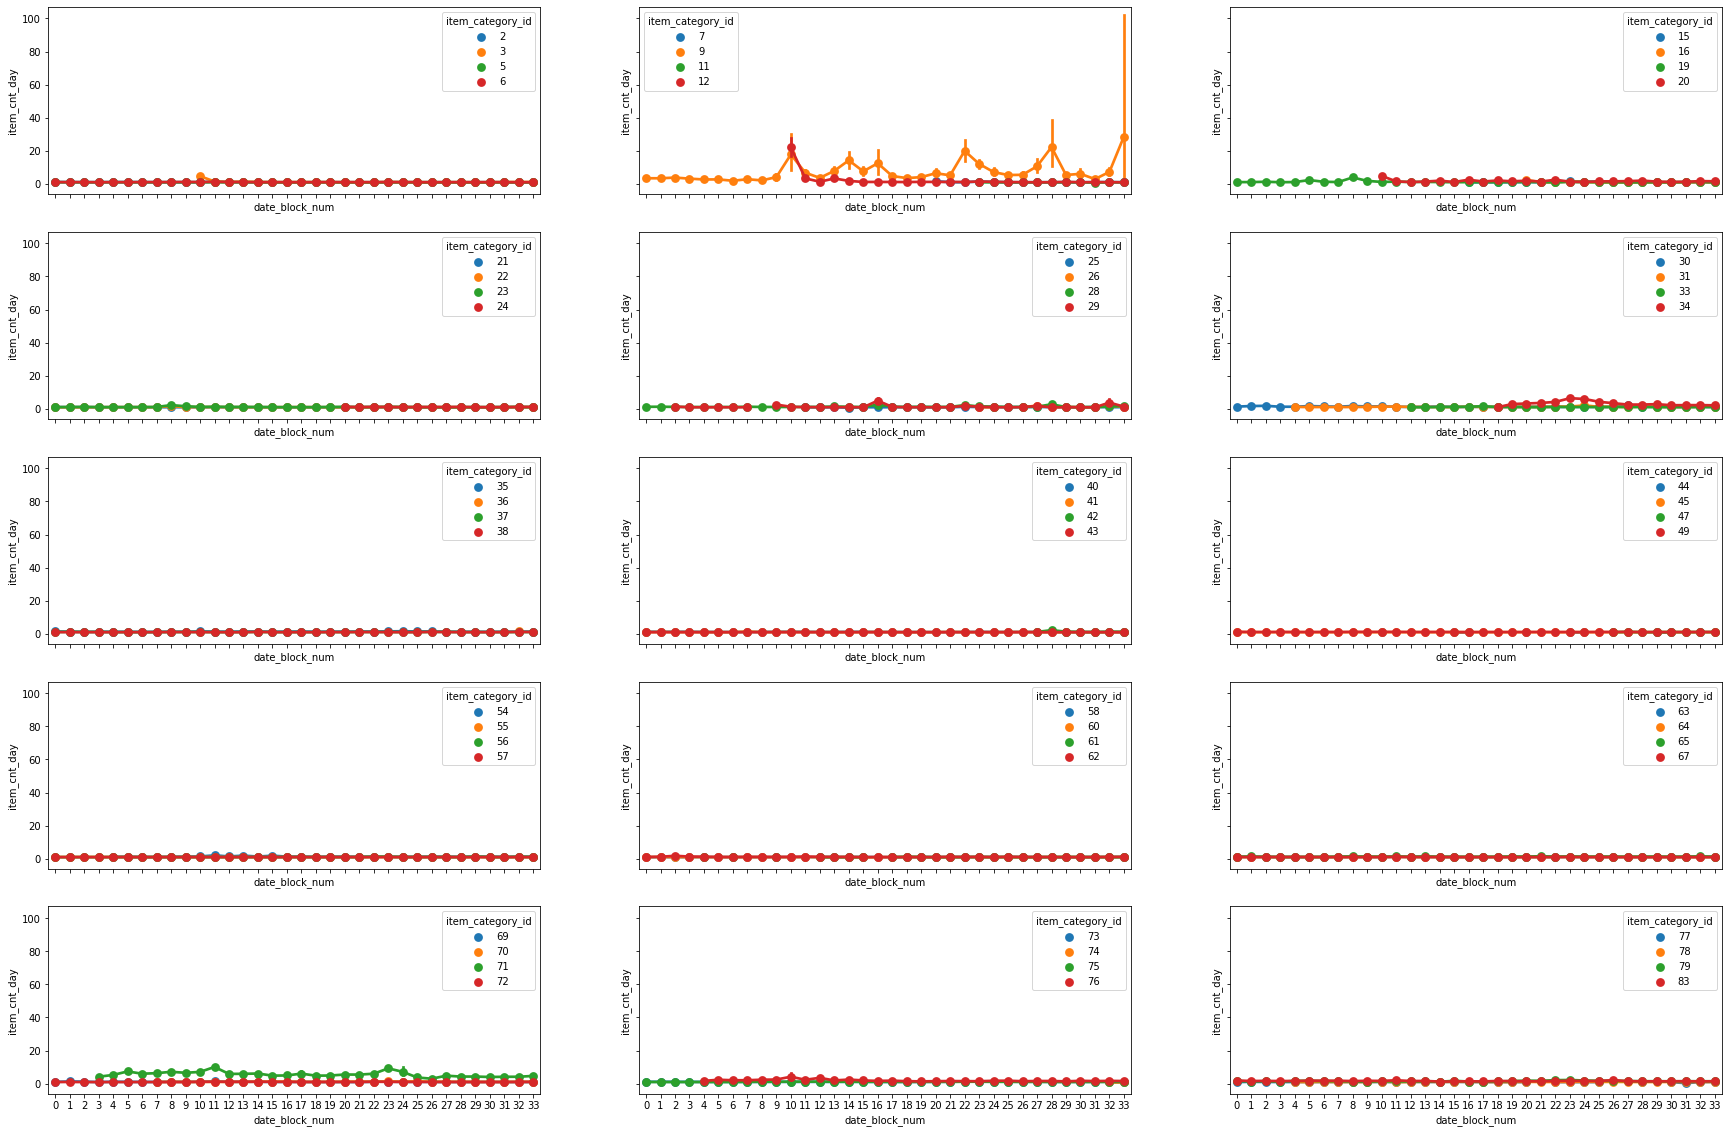

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(30,20))
count=-1
for i in range(5):
    for j in range(3):
        count+=1
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', data=df_train[df_train.item_category_id.isin(cats[count])], ax=axes[i][j])

kategori bir fark yaratmiyor gibi

## Prepare Data for Deep Learning

pivot table olusturucaz:
- index = row icin
- values = tablodaki veriler
- columns = sutunlar
- fill_value = eksik degerlere ne olacagi
- aggfunc = ayni sey varsa ne olsun
- reset.index = indexleri sifirlar

In [17]:
df_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [18]:
train = df_train.copy()
train = train.pivot_table(index=['shop_id', 'item_id'],values=['item_cnt_day'],columns=['date_block_num'],  fill_value=0, aggfunc='sum').reset_index()
train.head()

shop_id item_id item_cnt_day                                    \
date_block_num                            0   1  2  3  4  5  6  7  8  9 10 11   
0                    0      30            0  31  0  0  0  0  0  0  0  0  0  0   
1                    0      31            0  11  0  0  0  0  0  0  0  0  0  0   
2                    0      32            6  10  0  0  0  0  0  0  0  0  0  0   
3                    0      33            3   3  0  0  0  0  0  0  0  0  0  0   
4                    0      35            1  14  0  0  0  0  0  0  0  0  0  0   

                                                                               \
date_block_num 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32   
0               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
1               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
2               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
3               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
4               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   

                   
date_block_num 33  
0               0  
1               0  
2               0  
3               0  
4               0

In [19]:
df = pd.merge(df_test, train, on=['item_id', 'shop_id'], how='left')
df.fillna(0, inplace=True)
df.drop(columns = ['shop_id', 'item_id', 'ID'], inplace=True)
df.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# ilk 32 ayi X_train e atariz
X_train = np.expand_dims(df.values[:,:-1],axis = 2)
# 33. ayi y_train e
y_train = df.values[:,-1:]
# 1 den 33 e kadar olanlari da X_test e
X_test = np.expand_dims(df.values[:,1:],axis = 2)

print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


## Deep Learning

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

from keras.wrappers.scikit_learn import KerasClassifier

In [22]:
model = Sequential()

model.add(SimpleRNN(units= 64, activation='relu', use_bias= True, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units= 64, activation='relu', use_bias= True, return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units= 64, activation='relu', use_bias= True, return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units= 64))
model.add(Dropout(0.2))

model.add(Dense(units =1))

model.compile(optimizer = 'adam', loss ='mean_squared_error', metrics=['mse'])

model.summary()

2022-08-24 13:48:37.823819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 13:48:37.943123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 13:48:37.943915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 13:48:37.945669: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 33, 64)            4224      
_________________________________________________________________
dropout (Dropout)            (None, 33, 64)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 33, 64)            8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 64)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 33, 64)            8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 64)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                8

In [23]:
history=model.fit(X_train, y_train, validation_split=0.2, epochs = 15, batch_size = 4096)

Epoch 1/15


2022-08-24 13:48:40.995088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


42/42 [==============================] - 9s 138ms/step - loss: 37.6390 - mse: 37.6390 - val_loss: 1.1291 - val_mse: 1.1291
Epoch 2/15
42/42 [==============================] - 5s 130ms/step - loss: 37.3532 - mse: 37.3532 - val_loss: 1.0950 - val_mse: 1.0950
Epoch 3/15
42/42 [==============================] - 6s 139ms/step - loss: 37.2695 - mse: 37.2695 - val_loss: 1.0963 - val_mse: 1.0963
Epoch 4/15
42/42 [==============================] - 5s 130ms/step - loss: 37.2480 - mse: 37.2480 - val_loss: 1.0799 - val_mse: 1.0799
Epoch 5/15
42/42 [==============================] - 6s 141ms/step - loss: 37.1986 - mse: 37.1986 - val_loss: 1.0786 - val_mse: 1.0786
Epoch 6/15
42/42 [==============================] - 5s 129ms/step - loss: 37.1321 - mse: 37.1321 - val_loss: 1.0754 - val_mse: 1.0754
Epoch 7/15
42/42 [==============================] - 6s 153ms/step - loss: 37.1110 - mse: 37.1110 - val_loss: 1.0550 - val_mse: 1.0550
Epoch 8/15
42/42 [==============================] - 6s 134ms/step - loss:

In [24]:
y_predict = model.predict(X_test)

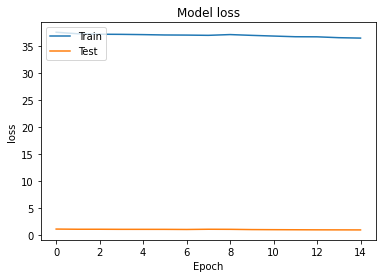

In [25]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

## Submission

In [26]:
submission = pd.DataFrame({'ID':df_test['ID'], 'item_cnt_month':y_predict.ravel()})
submission.head()

,ID,item_cnt_month
0,0,0.492554
1,1,0.090416
2,2,0.738186
3,3,0.127882
4,4,0.090416


In [27]:
submission.to_csv('submission.csv',index = False)